In [1]:
import os
import sys
import warnings
import logging

module_path = os.path.abspath('../src')
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from models.baseline_model import BaselineModel
from models.lstm_model import LSTMModel
from models.ensemble_model import EnsembleModel
from utils.preprocessor import Preprocessor
from utils.model_selection import back_test, grid_search

warnings.filterwarnings('ignore')
logging.getLogger('prophet').setLevel(logging.WARNING)

%matplotlib inline
%load_ext autoreload
%autoreload 2

Import and pre-process data

Percentage of outlier: 3.15377532228361%


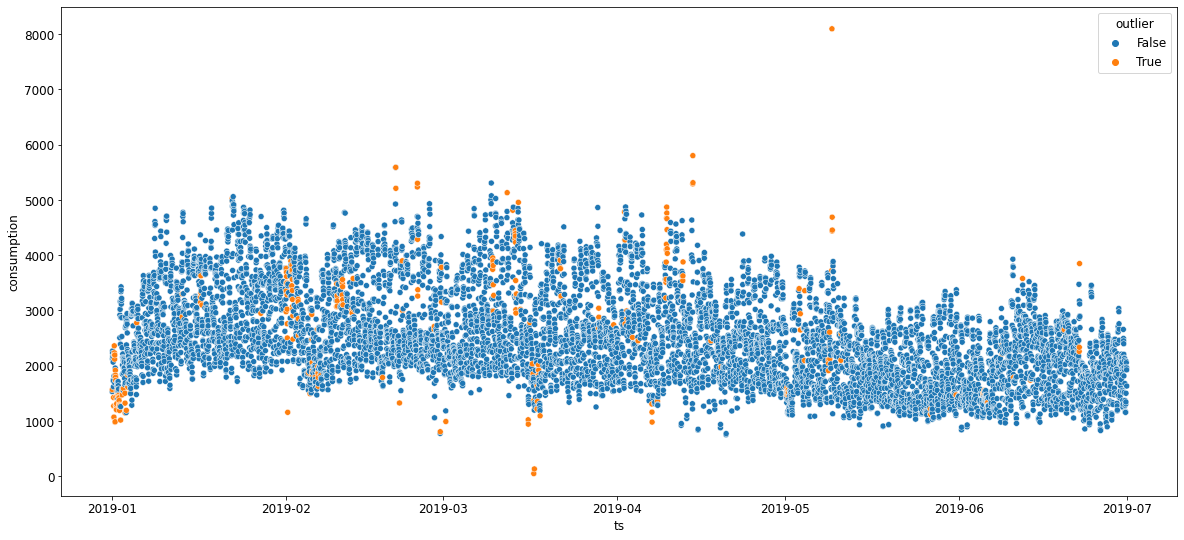

In [2]:
df_raw_scm = pd.read_csv('../data/scm_july16_feb20.csv', parse_dates=True, index_col='timestamp')
df_scm = df_raw_scm.loc['2019-01':'2019-06'].copy()
pp = Preprocessor(resample_freq='30min', na_th='2h', agg='mean', remove_outlier=True)
df_scm_pp = pp.fit(df_scm).transform(df_scm)

LSTM Model

2022-03-26 23:11:32.648218: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/1000
118/118 [==============================] - 66s 540ms/step - loss: 0.0664 - root_mean_squared_error: 0.2577 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1157 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 52s 438ms/step - loss: 0.0229 - root_mean_squared_error: 0.1513 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1073 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 58s 489ms/step - loss: 0.0219 - root_mean_squared_error: 0.1480 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1043 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 51s 430ms/step - loss: 0.0217 - root_mean_squared_error: 0.1473 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1024 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 38s 320ms/step - loss: 0.0217 - root_mean_squared_error: 0.1472 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1009 - lr: 0.0010
Epoch 6/1000
118/118 [============================

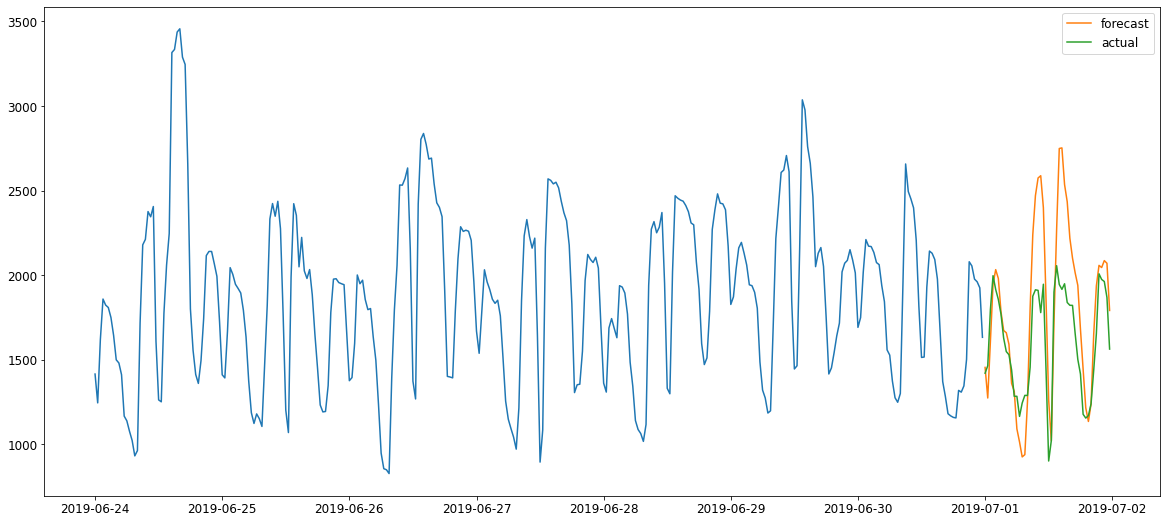

In [3]:
lstm = LSTMModel(freq='30min', horizon='1d')
res_lstm = lstm.fit(df_scm_pp).predict(df_scm_pp)
plt.figure(figsize=(20,9))
plt.plot(df_scm_pp.iloc[-48*7:].index, df_scm_pp.iloc[-48*7:].values)
plt.plot(res_lstm.index, res_lstm.values, label='forecast')
plt.plot(df_raw_scm['2019-07-01'].index, df_raw_scm['2019-07-01'].values, label='actual')
plt.legend()

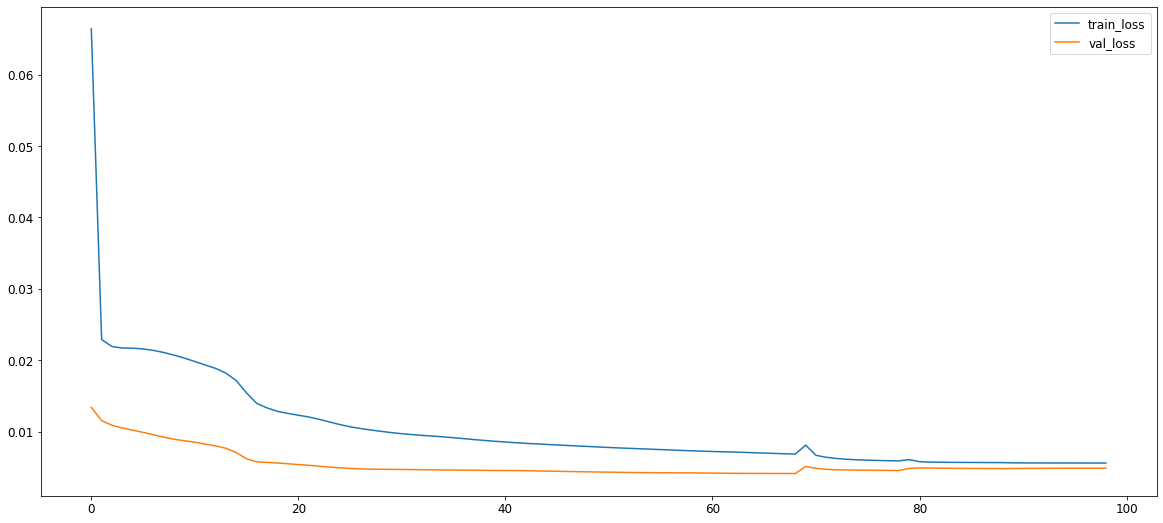

In [4]:
# plot training and validation loss
plt.figure(figsize=(20,9))
plt.plot(lstm.history.history['loss'], label='train_loss')
plt.plot(lstm.history.history['val_loss'], label='val_loss')
plt.legend()

Backtesting

In [5]:
baseline = BaselineModel()
lstm1 = LSTMModel(lstm_units=50, lstm_layers=1, dense_units=50, dense_layers=1, type='vanilla')
lstm2 = LSTMModel(lstm_units=50, type='encoder-decoder', stateful=False)
lstm3 = LSTMModel(lstm_units=100, type='encoder-decoder', stateful=True)

res = []
for f in [baseline, lstm1, lstm2, lstm3]:
    res_temp = back_test(f, df_scm_pp, test_size=0.2, stride='1d', retrain_stride=False)
    res_temp['model'] = f.name
    res.append(res_temp)

    print(f'===={f.name} model completed====')

pd.DataFrame(res).set_index('model')

====Baseline model completed====
Epoch 1/1000
92/92 [==============================] - 30s 307ms/step - loss: 0.0806 - root_mean_squared_error: 0.2839 - val_loss: 0.0157 - val_root_mean_squared_error: 0.1254 - lr: 0.0010
Epoch 2/1000
92/92 [==============================] - 28s 303ms/step - loss: 0.0261 - root_mean_squared_error: 0.1615 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1173 - lr: 0.0010
Epoch 3/1000
92/92 [==============================] - 27s 299ms/step - loss: 0.0245 - root_mean_squared_error: 0.1564 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1164 - lr: 0.0010
Epoch 4/1000
92/92 [==============================] - 28s 304ms/step - loss: 0.0238 - root_mean_squared_error: 0.1542 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1159 - lr: 0.0010
Epoch 5/1000
92/92 [==============================] - 28s 302ms/step - loss: 0.0235 - root_mean_squared_error: 0.1532 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1155 - lr: 0.0010
Epoch 6/1000
92/92 [=======

,rmse_mean,mse_mean,mae_mean,mape_mean,rmse_std,mse_std,mae_std,mape_std
model,,,,,,,,
Baseline,325.408678,122471.854169,255.650793,0.133359,130.593990,98615.469400,99.221537,0.056125
LSTM,304.706011,104173.626369,240.840146,0.131454,107.942239,79186.552137,80.554701,0.053515
LSTM,341.132795,122603.726851,273.515658,0.148597,80.063753,61689.176049,60.436903,0.041916
LSTM,312.960449,109546.563975,251.869874,0.137216,109.242008,84188.591993,80.870695,0.052384


Ensemble Method

=====Linear model training completed=====
Epoch 1/1000
118/118 [==============================] - 37s 299ms/step - loss: 0.0664 - root_mean_squared_error: 0.2577 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1157 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 36s 301ms/step - loss: 0.0229 - root_mean_squared_error: 0.1513 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1073 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 35s 297ms/step - loss: 0.0219 - root_mean_squared_error: 0.1480 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1043 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 35s 301ms/step - loss: 0.0217 - root_mean_squared_error: 0.1473 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1024 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 35s 297ms/step - loss: 0.0217 - root_mean_squared_error: 0.1472 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1009 - lr: 0.0010
Epoch 6/

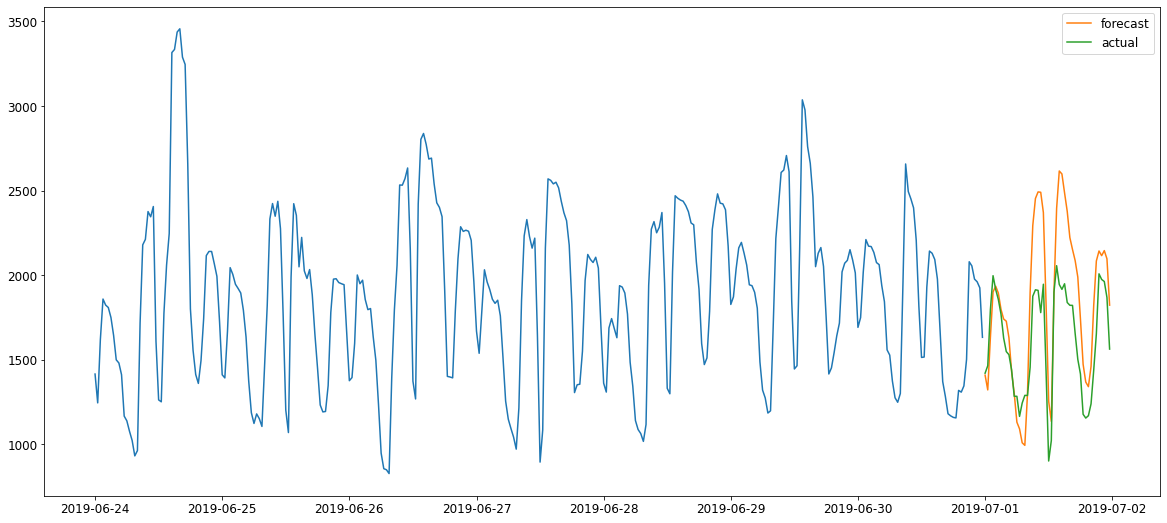

In [6]:
ensemble = EnsembleModel(freq='30min', horizon='1d', models=['Linear', 'LSTM'], ensemble_method='median')
res_ensemble = ensemble.fit(df_scm_pp).predict(df_scm_pp)

plt.figure(figsize=(20,9))
plt.plot(df_scm_pp.iloc[-48*7:].index, df_scm_pp.iloc[-48*7:].values)
plt.plot(res_ensemble.index, res_ensemble.values, label='forecast')
plt.plot(df_raw_scm['2019-07-01'].index, df_raw_scm['2019-07-01'].values, label='actual')
plt.legend()

Grid Search

In [7]:
lstm = LSTMModel(freq='30min', horizon='1d', type='encoder-decoder', stateful=True)
params = {
    'batch_size': [64],
    'lstm_units': [50, 100],
    'cyclic_feature_encoding': ['sincos'],
    'early_stopping_patience': [10, 30],
}
grid_search(lstm, params, df_scm_pp, test_size=0.05, stride='1d', retrain_stride=False)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/1000
112/112 [==============================] - 36s 303ms/step - loss: 0.0694 - root_mean_squared_error: 0.2634 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1232 - lr: 0.0010
Epoch 2/1000
112/112 [==============================] - 33s 295ms/step - loss: 0.0242 - root_mean_squared_error: 0.1557 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1193 - lr: 0.0010
Epoch 3/1000
112/112 [==============================] - 33s 298ms/step - loss: 0.0231 - root_mean_squared_error: 0.1521 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1193 - lr: 0.0010
Epoch 4/1000
112/112 [==============================] - 33s 299ms/step - loss: 0.0229 - root_mean_squared_error: 0.1514 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1189 - lr: 0.0010
Epoch 5/1000
112/112 [==============================] - 33s 297ms/step - loss: 0.0229 - root_mean_squared_error: 0.1512 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1180 - lr: 0.0010
Epoch 6/1000
112/112 [============================

 25%|██▌       | 1/4 [46:00<2:18:00, 2760.06s/it]

Epoch 1/1000
112/112 [==============================] - 36s 303ms/step - loss: 0.0694 - root_mean_squared_error: 0.2634 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1232 - lr: 0.0010
Epoch 2/1000
112/112 [==============================] - 33s 296ms/step - loss: 0.0242 - root_mean_squared_error: 0.1557 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1193 - lr: 0.0010
Epoch 3/1000
112/112 [==============================] - 33s 297ms/step - loss: 0.0231 - root_mean_squared_error: 0.1521 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1193 - lr: 0.0010
Epoch 4/1000
112/112 [==============================] - 33s 293ms/step - loss: 0.0229 - root_mean_squared_error: 0.1514 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1189 - lr: 0.0010
Epoch 5/1000
112/112 [==============================] - 33s 299ms/step - loss: 0.0229 - root_mean_squared_error: 0.1512 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1180 - lr: 0.0010
Epoch 6/1000
112/112 [============================

 50%|█████     | 2/4 [1:42:40<1:44:33, 3136.78s/it]

Epoch 1/1000
112/112 [==============================] - 58s 500ms/step - loss: 0.0531 - root_mean_squared_error: 0.2305 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1187 - lr: 0.0010
Epoch 2/1000
112/112 [==============================] - 55s 488ms/step - loss: 0.0230 - root_mean_squared_error: 0.1516 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1185 - lr: 0.0010
Epoch 3/1000
112/112 [==============================] - 55s 491ms/step - loss: 0.0230 - root_mean_squared_error: 0.1518 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1173 - lr: 0.0010
Epoch 4/1000
112/112 [==============================] - 55s 492ms/step - loss: 0.0225 - root_mean_squared_error: 0.1501 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1136 - lr: 0.0010
Epoch 5/1000
112/112 [==============================] - 55s 494ms/step - loss: 0.0220 - root_mean_squared_error: 0.1483 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1103 - lr: 0.0010
Epoch 6/1000
112/112 [============================

 75%|███████▌  | 3/4 [2:47:14<57:53, 3473.54s/it]  

Epoch 1/1000
112/112 [==============================] - 57s 496ms/step - loss: 0.0531 - root_mean_squared_error: 0.2305 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1187 - lr: 0.0010
Epoch 2/1000
112/112 [==============================] - 55s 491ms/step - loss: 0.0230 - root_mean_squared_error: 0.1516 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1185 - lr: 0.0010
Epoch 3/1000
112/112 [==============================] - 54s 485ms/step - loss: 0.0230 - root_mean_squared_error: 0.1518 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1173 - lr: 0.0010
Epoch 4/1000
112/112 [==============================] - 55s 491ms/step - loss: 0.0225 - root_mean_squared_error: 0.1501 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1136 - lr: 0.0010
Epoch 5/1000
112/112 [==============================] - 55s 495ms/step - loss: 0.0220 - root_mean_squared_error: 0.1483 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1103 - lr: 0.0010
Epoch 6/1000
112/112 [============================

100%|██████████| 4/4 [4:42:38<00:00, 4239.58s/it]


,parameter,rmse_mean,mse_mean,mae_mean,mape_mean,rmse_std,mse_std,mae_std,mape_std,model
0,"{'batch_size': 64, 'lstm_units': 50, 'cyclic_f...",284.997448,91953.055486,216.968118,0.117365,109.866731,66624.259245,77.571120,0.041849,LSTM
1,"{'batch_size': 64, 'lstm_units': 50, 'cyclic_f...",284.997448,91953.055486,216.968118,0.117365,109.866731,66624.259245,77.571120,0.041849,LSTM
2,"{'batch_size': 64, 'lstm_units': 100, 'cyclic_...",283.006621,90440.839508,211.806467,0.115189,107.896263,66274.245475,65.957553,0.033170,LSTM
3,"{'batch_size': 64, 'lstm_units': 100, 'cyclic_...",293.399492,97588.886405,220.517879,0.119758,113.770943,70264.425172,71.331343,0.038002,LSTM


Randomized Search

In [26]:
from forecaster import AutomatedForecasting
af1 = AutomatedForecasting(models=['LSTM'], method='randomized_search', iteration=1)
af1.fit(df_scm_pp)

LSTM


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1000
46/46 [==============================] - 76s 2s/step - loss: 0.0507 - root_mean_squared_error: 0.2252 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1184 - lr: 0.0057
Epoch 2/1000
46/46 [==============================] - 63s 1s/step - loss: 0.0309 - root_mean_squared_error: 0.1759 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1183 - lr: 0.0057
Epoch 3/1000
46/46 [==============================] - 63s 1s/step - loss: 0.0313 - root_mean_squared_error: 0.1769 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1192 - lr: 0.0057
Epoch 4/1000
46/46 [==============================] - 63s 1s/step - loss: 0.0310 - root_mean_squared_error: 0.1761 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1200 - lr: 0.0057
Epoch 5/1000
46/46 [==============================] - 63s 1s/step - loss: 0.0306 - root_mean_squared_error: 0.1748 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1193 - lr: 0.0057
Epoch 6/1000
46/46 [==============================] - 63s 1s/step - loss: 0

100%|██████████| 1/1 [57:53<00:00, 3473.17s/it]


                                           parameter   rmse_mean  \
0  {'batch_size': 128, 'cyclic_feature_encoding':...  385.068147   

        mse_mean    mae_mean  mape_mean    rmse_std       mse_std   mae_std  \
0  158429.666882  321.853123   0.192075  102.187334  94456.099176  86.52962   

   mape_std model  
0  0.066796  LSTM  
Epoch 1/1000
59/59 [==============================] - 72s 1s/step - loss: 0.0430 - root_mean_squared_error: 0.2073 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1091 - lr: 0.0057
Epoch 2/1000
59/59 [==============================] - 70s 1s/step - loss: 0.0266 - root_mean_squared_error: 0.1630 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1051 - lr: 0.0057
Epoch 3/1000
59/59 [==============================] - 71s 1s/step - loss: 0.0281 - root_mean_squared_error: 0.1677 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1052 - lr: 0.0057
Epoch 4/1000
59/59 [==============================] - 70s 1s/step - loss: 0.0279 - root_mean_squared_error: 0

AutomatedForecasting(iteration=1, method='randomized_search', models=['LSTM'])

In [27]:
af1.df_res

,parameter,rmse_mean,mse_mean,mae_mean,mape_mean,rmse_std,mse_std,mae_std,mape_std,model
0,"{'batch_size': 128, 'cyclic_feature_encoding':...",385.068147,158429.666882,321.853123,0.192075,102.187334,94456.099176,86.52962,0.066796,LSTM


Bayesian Search

In [28]:
from forecaster import AutomatedForecasting
af2 = AutomatedForecasting(models=['LSTM'], method='bayesian', iteration=1)
af2.fit(df_scm_pp)

LSTM                                                 
{'batch_size': 256, 'cyclic_feature_encoding': 'onehot', 'dense_layers': 4.0, 'dense_units': 120.0, 'factor': 0.6255634521809594, 'lr': 0.0015417473585399937, 'lstm_layers': 2.0, 'lstm_units': 120.0, 'stateful': False, 'type': 'vanilla'}
Epoch 1/1000                                         

23/23 [==============================] - 110s 5s/step - loss: 0.0789 - root_mean_squared_error: 0.2810 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1278 - lr: 0.0015

Epoch 2/1000                                         

23/23 [==============================] - 106s 5s/step - loss: 0.0333 - root_mean_squared_error: 0.1823 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1188 - lr: 0.0015

Epoch 3/1000                                         

23/23 [==============================] - 107s 5s/step - loss: 0.0334 - root_mean_squared_error: 0.1828 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1387 - lr: 0.0015

Epoch 4/1000         

AutomatedForecasting(iteration=1, models=['LSTM'])

In [29]:
af2.df_res

,parameter,0,0
0,"{'batch_size': 256, 'cyclic_feature_encoding':...",327.641313,LSTM
